In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# https://hackanons.com/2020/12/python-extract-data-from-json-file.html
def open_file(file):
    with open("json_files/"+file) as f:
        json_data = json.load(f)
    return json_data

# print(json_data)

In [3]:
# https://www.geeksforgeeks.org/python-accessing-key-value-in-dictionary/
print ("Dict keys 1 are : ")
dict_keys1 = [k for k in json_data[0]]
print(dict_keys1)

values1 = [json_data[0][k] for k in json_data[0]]
print ("Dict keys 2 are : ")
dict_keys2 = [k for k in values1[1]]
print(dict_keys2)

print ("Values are : ")
values2 = [values1[1][k] for k in values1[1]]
print(values2)

# And then we are interested in values2[0]

heart_rate = np.zeros(len(json_data))

for i in range(len(json_data)):
    values1 = [json_data[i][k] for k in json_data[i]]
    values2 = [values1[1][k] for k in values1[1]]
    heart_rate[i] = values2[0]

Dict keys 1 are : 
['dateTime', 'value']
Dict keys 2 are : 
['bpm', 'confidence']
Values are : 
[61, 3]


In [6]:
# First approximation to obtain heart rate data
# Note this does not consider the time axis in a consistent manner.

def extract_hr(json_data):
    heart_rate = np.zeros(len(json_data))

    for i in range(len(json_data)):
        values1 = [json_data[i][k] for k in json_data[i]]
        values2 = [values1[1][k] for k in values1[1]]
        heart_rate[i] = values2[0]
        
    return heart_rate

# Simple idea. Divide data in ~5s time bins, obtain average of heart rate and standard deviation. Plot this in a 2D plot. Use K-means to classify.

In [7]:
# Function that separates a string where the separator is

# https://stackoverflow.com/questions/4697006/python-split-string-by-list-of-separators
def split(txt, seps):
    default_sep = seps[0]

    # we skip seps[0] because that's the default separator
    for sep in seps[1:]:
        txt = txt.replace(sep, default_sep)
    return [i.strip() for i in txt.split(default_sep)]

In [8]:
# Extract different time formats arrays from json

def splitting_data(json_data):
    
    dict_keys1 = [k for k in json_data[0]]
    times = [json_data[k][dict_keys1[0]] for k in range(len(json_data))] # dateTime
    
    only_time = [split(times[k], ' ')[1] for k in range(len(times))]
    hms = [split(only_time[k], ":") for k in range(len(times))] #hour minute second

    # The index will represent the second of the day. Total of 86 400 seconds in one day

    # Converting the time to the number of second of the day
    seconds = [int(hms[k][0])*3600 + int(hms[k][1])*60 + int(hms[k][2]) for k in range(len(hms))]

    return times, only_time, hms, seconds

In [9]:
times, only_time, hms, seconds = splitting_data(json_data)

print(times[0])
print(only_time[0])
print(hms[0])
print(seconds[0])

08/31/21 05:00:03
05:00:03
['05', '00', '03']
18003


In [10]:
print(only_time[7900])
print(hms[7900])
print(np.argmin(seconds))

00:00:13
['00', '00', '13']
7900


In [11]:
print(times[7899])

print(times[7900])

08/31/21 23:59:58
09/01/21 00:00:13


Good to know, we are handling data from two days. Not everything in this file corresponds to the day 8/31/2021

In [12]:
# First challenge, divide everything in 5min time bins, that is in 5*60 = 300 s time bins!
def data_5s(json_data):
    
    times, only_time, hms, seconds = splitting_data(json_data)
    
    vecs_sec = []
    vecs_indices = []

    for i in range(288): # Number of 5 min periods in 24 hours
        vec_sec = []
        vec_indices = []
        banner = False

        for index_i in range(7900): # len(indices)

            if i*300 <= seconds[index_i] and seconds[index_i] < (i+1)*300:
                vec_sec.append(seconds[index_i])
                vec_indices.append(index_i)
                banner = True

            elif banner == True:
                vecs_sec.append(vec_sec)
                vecs_indices.append(vec_indices)
                break
                
    return vecs_sec, vecs_indices

In [49]:
def obtain_time_series(file_name):
    json_data = open_file(file_name)
    
    times, only_time, hms, seconds = splitting_data(json_data)
    # Seconds has the correct x-entries for the heart rate time series
    
    heart_rate = np.zeros(len(json_data))

    for i in range(len(json_data)):
        values1 = [json_data[i][k] for k in json_data[i]]
        values2 = [values1[1][k] for k in values1[1]]
        heart_rate[i] = values2[0]
        
    return np.asarray(seconds), heart_rate

In [50]:
# Magic number, number of seconds in one day 
print(300*288)
print(24*3600)

86400
86400


In [51]:
# Obtain the heart rate mean of these intervals as well as their standard deviation

def obtain_data(file_name):
    json_data = open_file(file_name)
    
    vecs_secs, vecs_indices = data_5s(json_data)
    
    means  = np.zeros(len(vecs_indices))
    stdevs = np.zeros(len(vecs_indices))

    for i in range(len(vecs_indices)):
        means[i] = np.mean(heart_rate[vecs_indices[i]]) # Wait, when did you define: heart_rate_31_8 ???
        stdevs[i] = np.std(heart_rate[vecs_indices[i]])
        
    return means, stdevs

In [52]:
means_31_8, stdevs_31_8 = obtain_data("heart_rate-2021-08-31.json") # means, stdevs
means_01_9, stdevs_01_9 = obtain_data("heart_rate-2021-09-01.json")
means_02_9, stdevs_02_9 = obtain_data("heart_rate-2021-09-02.json")

seconds_31_8, heart_frequency_31_8 = obtain_time_series("heart_rate-2021-08-31.json")
seconds_01_9, heart_frequency_01_9 = obtain_time_series("heart_rate-2021-09-01.json")
seconds_02_9, heart_frequency_02_9 = obtain_time_series("heart_rate-2021-09-02.json")

# Why is there a line that crosses from the first point to the last one?

Because the time series is in that manner, when it reaches midnight, a new day starts, but the plot just starts back at 0 instead of continuing to hour 25.

Maybe you could generate a big array concatenating multiple arrays. And then separating them at 10 in the morning or such. So you can also have complete sleep periods.

In [55]:
seconds_31_8

array([18003, 18008, 18023, ..., 17960, 17975, 17990])

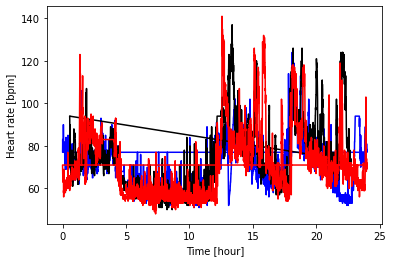

In [56]:
plt.plot(seconds_31_8/3600, heart_frequency_31_8, c="b")
plt.plot(seconds_01_9/3600, heart_frequency_01_9, c="k")
plt.plot(seconds_02_9/3600, heart_frequency_02_9, c="r")
plt.xlabel("Time [hour]")
plt.ylabel("Heart rate [bpm]")
plt.show()

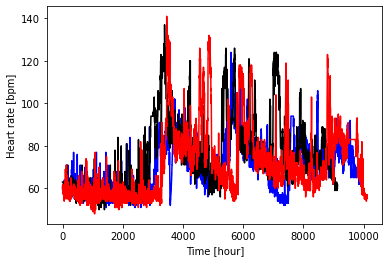

In [57]:
plt.plot(heart_frequency_31_8, c="b")
plt.plot(heart_frequency_01_9, c="k")
plt.plot(heart_frequency_02_9, c="r")
plt.xlabel("Time [hour]")
plt.ylabel("Heart rate [bpm]")
plt.show()

In [59]:
means_31_8, stdevs_31_8 = obtain_data("heart_rate-2021-08-31.json")
means_01_9, stdevs_01_9 = obtain_data("heart_rate-2021-09-01.json")
means_02_9, stdevs_02_9 = obtain_data("heart_rate-2021-09-02.json")

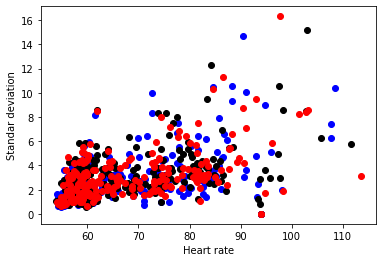

In [60]:
plt.scatter(means_31_8, stdevs_31_8, c = "b")
plt.scatter(means_01_9, stdevs_01_9, c="k")
plt.scatter(means_02_9, stdevs_02_9, c="r")
plt.xlabel("Heart rate")
plt.ylabel("Standar deviation") # Heart rate variability
plt.show()

Now comes the interesting part, cluster these datapoints!

Wait, before the clustering begins, I want to see how the time series looks with the correct time axis. Modify the previous functions accordingly.